In [1]:
import os
import numpy as np
import torch

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Set paths for clean and contaminated EEG data
clean_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Clean"
contaminated_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Contaminated"

# Define EEG frequency bands
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]

print(f"✅ Clean EEG Directory: {clean_dir}")
print(f"✅ Contaminated EEG Directory: {contaminated_dir}")
print(f"✅ EEG Bands: {bands}")


✅ Using device: cuda
✅ Clean EEG Directory: /home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Clean
✅ Contaminated EEG Directory: /home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Contaminated
✅ EEG Bands: ['Delta_band', 'Theta_band', 'Alpha_band', 'Beta_band', 'Gamma_band', 'High_Frequencies_band']


In [2]:
import torch.nn as nn
import torch

class ResCNN1D(nn.Module):
    def __init__(self, input_length=512):
        super(ResCNN1D, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)

        # Residual Block with Two Convolutions
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)

        # ✅ FIXED: Residual Connection Now Matches the Input Channels
        self.residual = nn.Conv1d(64, 64, kernel_size=1, stride=1)

        # Final Convolutional Refinement
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(64)

        # Fully Connected Layer for Reconstruction
        self.fc = nn.Linear(input_length * 64, input_length)

    def forward(self, x):
        # Ensure input is 3D (batch, channels, sequence)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add channel dimension if missing

        # First Conv Layer
        x = torch.relu(self.bn1(self.conv1(x)))

        # ✅ FIXED: Residual Path (Now Uses Correct Input Shape)
        residual = self.residual(x)  # Now it expects 64 channels

        # Residual Block (2 Conv Layers)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))

        # Merge Residual and Main Path
        x = x + residual  # Residual Learning

        # Final Convolutional Refinement
        x = torch.relu(self.bn4(self.conv4(x)))

        # Flatten before fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layer for Reconstruction
        x = self.fc(x)

        return x

# Print confirmation
print("✅ Fixed ResCNN1D Model Defined Successfully!")


✅ Fixed ResCNN1D Model Defined Successfully!


In [3]:
import torch.optim as optim

# Define Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

# Define Loss Function (MSE)
criterion = nn.MSELoss()

# Define Optimizer (Adam)
input_length = 512  # EEG signal length
model = ResCNN1D().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping instance
early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

# Print confirmation
print("✅ Loss function, optimizer, and early stopping defined successfully!")


✅ Loss function, optimizer, and early stopping defined successfully!


In [4]:
from sklearn.model_selection import train_test_split

def load_and_split_data(band_name):
    """
    Loads EEG data for a specific frequency band, splits into train and test sets based on SNR levels.
    """
    print(f"\n📌 Loading and Splitting Data for {band_name}...")

    # Load clean EEG data
    clean_band_path = os.path.join(clean_dir, f"{band_name}.npy")
    clean_band = np.load(clean_band_path)

    # Load contaminated EEG data across all SNR levels
    contaminated_band = []
    snr_labels = []

    for snr_folder in sorted(os.listdir(contaminated_dir)):  # Iterate through SNR folders
        contaminated_band_path = os.path.join(contaminated_dir, snr_folder, f"{band_name}.npy")
        contaminated_data = np.load(contaminated_band_path)

        contaminated_band.append(contaminated_data)
        snr_labels.extend([snr_folder] * len(contaminated_data))  # Track SNR levels

    # Convert lists to numpy arrays
    contaminated_band = np.concatenate(contaminated_band, axis=0)
    # Convert string labels ("SNR_-7") to integers (-7)
    
    snr_labels = np.array([int(snr.replace("SNR_", "")) for snr in snr_labels])


    # Ensure clean_band is correctly repeated to match contaminated EEG samples
    clean_band_repeated = np.tile(clean_band, (len(contaminated_band) // len(clean_band) + 1, 1))[:len(contaminated_band)]

    # Stratified Train-Test Split
    train_clean, test_clean, train_contaminated, test_contaminated, snr_labels_train, snr_labels_test = train_test_split(
        clean_band_repeated, contaminated_band, snr_labels, test_size=0.2, stratify=snr_labels, random_state=42
    )

    # Inspect data shapes
    print(f"✅ {band_name} Train Clean Shape: {train_clean.shape}, Test Clean Shape: {test_clean.shape}")
    print(f"✅ {band_name} Train Contaminated Shape: {train_contaminated.shape}, Test Contaminated Shape: {test_contaminated.shape}")
    print(f"✅ {band_name} SNR Labels Train: {np.unique(snr_labels_train)}, Test: {np.unique(snr_labels_test)}")

    return train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test

# Load and split data for each EEG band
train_data = {}
test_data = {}

for band in bands:
    train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test = load_and_split_data(band)
    train_data[band] = (train_clean, train_contaminated)
    test_data[band] = (test_clean, test_contaminated, snr_labels_test)

print("\n✅ All EEG bands successfully loaded and split!")



📌 Loading and Splitting Data for Delta_band...
✅ Delta_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Delta_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Delta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Theta_band...
✅ Theta_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Theta_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Theta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Alpha_band...
✅ Alpha_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Alpha_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Alpha_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Beta_band...
✅ Bet

In [5]:
from torch.utils.data import DataLoader, TensorDataset

def train_cnn(train_clean, train_contaminated, test_clean, test_contaminated, band_name):
    """
    Trains the CNN model for EEG denoising on a specific frequency band.
    """
    print(f"\n🚀 Training CNN for {band_name}...")

    # Convert NumPy arrays to PyTorch tensors and move to GPU
    train_clean = torch.tensor(train_clean, dtype=torch.float32).unsqueeze(1).to(device)
    test_clean = torch.tensor(test_clean, dtype=torch.float32).unsqueeze(1).to(device)
    train_contaminated = torch.tensor(train_contaminated, dtype=torch.float32).unsqueeze(1).to(device)
    test_contaminated = torch.tensor(test_contaminated, dtype=torch.float32).unsqueeze(1).to(device)

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(train_contaminated, train_clean)
    test_dataset = TensorDataset(test_contaminated, test_clean)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    # Define model, optimizer, and loss function
    input_length = train_contaminated.shape[2]  # EEG signal length
    model = ResCNN1D().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

    # Train model
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Evaluate model
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.squeeze(1))
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

        # Early stopping condition
        early_stopping(avg_test_loss)
        if early_stopping.stop_training:
            print(f"✅ Early stopping triggered for {band_name} at epoch {epoch + 1}")
            break

    # Generate denoised test set predictions
    with torch.no_grad():
        denoised_band = model(test_contaminated).squeeze(1).cpu().numpy()

    return denoised_band, test_clean.cpu().numpy()


In [6]:
denoised_bands = []
clean_bands = []

for band in bands:
    train_clean, train_contaminated = train_data[band]
    test_clean, test_contaminated, _ = test_data[band]

    denoised_band, clean_band_test = train_cnn(train_clean, train_contaminated, test_clean, test_contaminated, band)
    
    denoised_bands.append(denoised_band)
    clean_bands.append(clean_band_test)

print("\n✅ All EEG bands successfully trained!")



🚀 Training CNN for Delta_band...
Epoch 1: Train Loss = 6295.9695, Test Loss = 6212.6928
Epoch 2: Train Loss = 6007.1795, Test Loss = 6088.8335
Epoch 3: Train Loss = 5926.4911, Test Loss = 5974.3587
Epoch 4: Train Loss = 5833.8785, Test Loss = 5915.1102
Epoch 5: Train Loss = 5769.3475, Test Loss = 5905.6041
Epoch 6: Train Loss = 5731.0461, Test Loss = 5874.8400
Epoch 7: Train Loss = 5671.8158, Test Loss = 5830.3735
Epoch 8: Train Loss = 5622.3389, Test Loss = 5804.2018
Epoch 9: Train Loss = 5593.3751, Test Loss = 5777.0574
Epoch 10: Train Loss = 5553.2486, Test Loss = 5757.8943
Epoch 11: Train Loss = 5515.4090, Test Loss = 5790.9214
Epoch 12: Train Loss = 5474.2144, Test Loss = 5741.5352
Epoch 13: Train Loss = 5446.4267, Test Loss = 5683.6362
Epoch 14: Train Loss = 5406.3728, Test Loss = 5743.7519
Epoch 15: Train Loss = 5396.0807, Test Loss = 5665.2430
Epoch 16: Train Loss = 5358.5182, Test Loss = 5656.8240
Epoch 17: Train Loss = 5337.9974, Test Loss = 5630.4342
Epoch 18: Train Loss = 

In [7]:
# Reconstruct full EEG signals from denoised frequency bands
denoised_eeg = np.sum(denoised_bands, axis=0)  # Sum across frequency bands
clean_eeg = np.sum(clean_bands, axis=0)

# Ensure both arrays have the same shape
clean_eeg = clean_eeg.squeeze(1)  # Remove extra dimension if it exists

print(f"✅ Fixed EEG Reconstruction: Denoised EEG Shape: {denoised_eeg.shape}, Clean EEG Shape: {clean_eeg.shape}")


✅ Fixed EEG Reconstruction: Denoised EEG Shape: (6800, 512), Clean EEG Shape: (6800, 512)


In [8]:
import numpy as np
from scipy.signal import welch

# Compute RRMSE in time domain
def compute_rrmse_t(clean, denoised):
    per_sample_rrmse = np.sqrt(np.sum((clean - denoised) ** 2, axis=1) / np.sum(clean ** 2, axis=1))
    return np.mean(per_sample_rrmse)

# Compute RRMSE in frequency domain using Power Spectral Density (PSD)
def compute_rrmse_s(clean, denoised, fs=512):
    f_clean, psd_clean = welch(clean.flatten(), fs=fs, nperseg=512)
    f_denoised, psd_denoised = welch(denoised.flatten(), fs=fs, nperseg=512)
    return np.sqrt(np.sum((psd_clean - psd_denoised) ** 2) / np.sum(psd_clean ** 2))

# Compute Correlation Coefficient (CC)
def compute_cc(clean, denoised):
    return np.corrcoef(clean.flatten(), denoised.flatten())[0, 1]

print("✅ Evaluation functions loaded!") 

✅ Evaluation functions loaded!


In [9]:
import pandas as pd

# Store evaluation results per SNR level
snr_metrics = {}

# Ensure snr_labels_test is a NumPy array
snr_labels_test = np.array(snr_labels_test).flatten()

# Evaluate each SNR level separately
for snr in np.unique(snr_labels_test):
    indices = np.where(snr_labels_test == snr)[0]  # Get test samples for this SNR

    clean_snr = clean_eeg[indices]
    denoised_snr = denoised_eeg[indices]

    # Compute evaluation metrics
    rrmse_t = compute_rrmse_t(clean_snr, denoised_snr)
    rrmse_s = compute_rrmse_s(clean_snr, denoised_snr, fs=512)
    cc = compute_cc(clean_snr, denoised_snr)
    ts_metric = 10 * np.log10(1 / (rrmse_t + rrmse_s))

    # Store metrics per SNR
    snr_metrics[snr] = {"RRMSE-T": rrmse_t, "RRMSE-S": rrmse_s, "CC": cc, "T&S Metric (dB)": ts_metric}

    print(f"  ✅ SNR {snr}: RRMSE-T = {rrmse_t:.4f}, RRMSE-S = {rrmse_s:.4f}, CC = {cc:.4f}, T&S Metric = {ts_metric:.4f} dB")

# Convert results to DataFrame for better visualization
df_snr_metrics = pd.DataFrame.from_dict(snr_metrics, orient="index")
df_snr_metrics.index.name = "SNR Level"

# Display results


  ✅ SNR -7: RRMSE-T = 0.5858, RRMSE-S = 0.1024, CC = 0.8386, T&S Metric = 1.6230 dB
  ✅ SNR -6: RRMSE-T = 0.4309, RRMSE-S = 0.1832, CC = 0.9146, T&S Metric = 2.1180 dB
  ✅ SNR -5: RRMSE-T = 0.4326, RRMSE-S = 0.2345, CC = 0.9149, T&S Metric = 1.7583 dB
  ✅ SNR -4: RRMSE-T = 0.4257, RRMSE-S = 0.2696, CC = 0.9129, T&S Metric = 1.5781 dB
  ✅ SNR -3: RRMSE-T = 0.4164, RRMSE-S = 0.2846, CC = 0.9159, T&S Metric = 1.5422 dB
  ✅ SNR -2: RRMSE-T = 0.4166, RRMSE-S = 0.3309, CC = 0.9123, T&S Metric = 1.2635 dB
  ✅ SNR -1: RRMSE-T = 0.3992, RRMSE-S = 0.3453, CC = 0.9189, T&S Metric = 1.2816 dB
  ✅ SNR 0: RRMSE-T = 0.3816, RRMSE-S = 0.3247, CC = 0.9259, T&S Metric = 1.5099 dB
  ✅ SNR 1: RRMSE-T = 0.3683, RRMSE-S = 0.3324, CC = 0.9286, T&S Metric = 1.5446 dB
  ✅ SNR 2: RRMSE-T = 0.3844, RRMSE-S = 0.3783, CC = 0.9230, T&S Metric = 1.1765 dB


In [10]:
# Compute the average of all SNR-based metrics
avg_rrmse_t = np.mean([metrics["RRMSE-T"] for metrics in snr_metrics.values()])
avg_rrmse_s = np.mean([metrics["RRMSE-S"] for metrics in snr_metrics.values()])
avg_cc = np.mean([metrics["CC"] for metrics in snr_metrics.values()])
avg_ts_metric = np.mean([metrics["T&S Metric (dB)"] for metrics in snr_metrics.values()])

# Print the final summary
print("\n==== Final Evaluation Summary ====")
print(f"✅ Average RRMSE-T: {avg_rrmse_t:.4f}")
print(f"✅ Average RRMSE-S: {avg_rrmse_s:.4f}")
print(f"✅ Average CC: {avg_cc:.4f}")
print(f"✅ Average T&S Metric (dB): {avg_ts_metric:.4f}")

# Create DataFrame for display



==== Final Evaluation Summary ====
✅ Average RRMSE-T: 0.4242
✅ Average RRMSE-S: 0.2786
✅ Average CC: 0.9106
✅ Average T&S Metric (dB): 1.5396


✅ SNR Labels Shape: (6800,), Clean EEG Shape: (6800, 512), Denoised EEG Shape: (6800, 512)
✅ Converted SNR Labels: [-7 -7 -2 -4  2  1  2 -2 -2 -4] ...

📊 Found 680 test samples for SNR Level -5
✅ SNR Level -5 indices in test set: [26, 29, 51, 61, 79, 82, 89, 91, 94, 95, 108, 115, 120, 129, 136, 159, 161, 167, 186, 188, 194, 212, 220, 225, 235, 240, 248, 279, 284, 315, 318, 325, 331, 333, 336, 345, 354, 369, 371, 372, 379, 381, 386, 406, 408, 416, 419, 421, 433, 439, 453, 460, 484, 488, 490, 506, 508, 512, 549, 574, 598, 605, 620, 632, 635, 691, 695, 696, 713, 724, 726, 734, 738, 749, 750, 752, 753, 756, 767, 775, 783, 793, 800, 801, 817, 818, 831, 840, 858, 865, 882, 883, 902, 914, 936, 940, 960, 965, 969, 977, 978, 979, 981, 982, 1004, 1009, 1019, 1020, 1036, 1044, 1052, 1070, 1079, 1084, 1086, 1088, 1108, 1111, 1112, 1116, 1117, 1129, 1151, 1158, 1168, 1191, 1194, 1208, 1216, 1244, 1245, 1251, 1267, 1276, 1292, 1293, 1308, 1316, 1331, 1359, 1363, 1365, 1377, 1384, 1447, 1450, 1457, 1

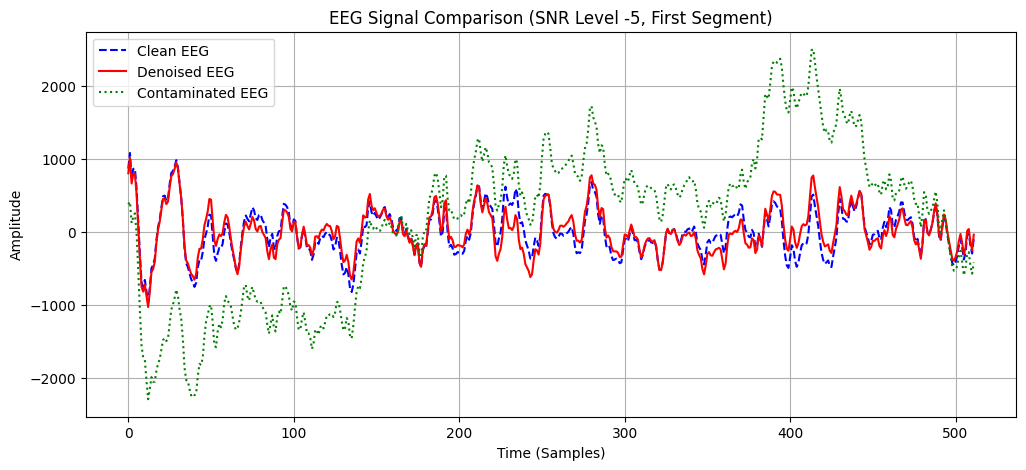

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure required variables are loaded
try:
    print(f"✅ SNR Labels Shape: {snr_labels_test.shape}, Clean EEG Shape: {clean_eeg.shape}, Denoised EEG Shape: {denoised_eeg.shape}")
except NameError:
    print("❌ Variables are not defined. Re-run the data preparation and evaluation cells.")

# ✅ Convert SNR labels to integers safely
try:
    snr_labels_test_int = np.array([int(str(snr).replace("SNR_", "")) for snr in snr_labels_test])
    print(f"✅ Converted SNR Labels: {snr_labels_test_int[:10]} ...")  # Show first 10 for debugging
except Exception as e:
    print(f"❌ Error converting SNR labels: {e}")

# Set SNR level to check
snr_level = -5  

# ✅ Extract indices of test samples for the selected SNR level
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

# ✅ Handle missing SNR level
if len(snr_indices) == 0:
    print(f"❌ No test samples found for SNR Level {snr_level}.")
else:
    print(f"\n📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
    print(f"✅ SNR Level {snr_level} indices in test set: {snr_indices.tolist()}")

    # ✅ Select the first segment
    first_segment_idx = snr_indices[0]

    # ✅ Extract EEG segments
    clean_segment = clean_eeg[first_segment_idx]
    denoised_segment = denoised_eeg[first_segment_idx]

    # ✅ Reconstruct Contaminated EEG by summing all frequency bands
    contaminated_bands = [test_data[band][1] for band in bands]
    contaminated_eeg = np.sum(contaminated_bands, axis=0)
    contaminated_segment = contaminated_eeg[first_segment_idx]

    # ✅ Plot EEG signals
    plt.figure(figsize=(12, 5))
    plt.plot(clean_segment, label="Clean EEG", linestyle="dashed", color="blue", linewidth=1.5)
    plt.plot(denoised_segment, label="Denoised EEG", linestyle="solid", color="red", linewidth=1.5)
    plt.plot(contaminated_segment, label="Contaminated EEG", linestyle="dotted", color="green", linewidth=1.5)
    
    plt.title(f"EEG Signal Comparison (SNR Level {snr_level}, First Segment)")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(denoised_segment)))      # X-axis: time/sample index
y_points = denoised_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Denoised EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Denoised EEG Plotting Points:
(0, 802.7042236328125)
(1, 1011.547119140625)
(2, 662.06103515625)
(3, 791.9271240234375)
(4, 796.7257080078125)
(5, 516.5006103515625)
(6, 65.81320190429688)
(7, -363.40008544921875)
(8, -755.2138671875)
(9, -820.282958984375)
(10, -724.9365234375)
(11, -875.201416015625)
(12, -1030.278076171875)
(13, -816.7106323242188)
(14, -549.7471313476562)
(15, -509.9530334472656)
(16, -411.3746337890625)
(17, -149.66400146484375)
(18, 33.696651458740234)
(19, 138.6459197998047)
(20, 301.91845703125)
(21, 451.80596923828125)
(22, 455.66986083984375)
(23, 378.64373779296875)
(24, 415.03179931640625)
(25, 609.209228515625)
(26, 763.4298095703125)
(27, 791.29736328125)
(28, 860.41162109375)
(29, 953.8699951171875)
(30, 863.9053955078125)
(31, 655.232177734375)
(32, 464.23223876953125)
(33, 162.6617431640625)
(34, -207.6740264892578)
(35, -393.37359619140625)
(36, -432.08203125)
(37, -508.8241882324219)
(38, -576.8667602539062)
(39, -605.3140869140625)
(40, -656.0989990

In [13]:
x_points = list(range(len(clean_segment)))      # X-axis: time/sample index
y_points = clean_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Clean EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Clean EEG Plotting Points:
(0, 866.0310668945312)
(1, 1079.484130859375)
(2, 731.6409301757812)
(3, 862.6738891601562)
(4, 866.7140502929688)
(5, 588.8504028320312)
(6, 136.66143798828125)
(7, -298.35662841796875)
(8, -691.608642578125)
(9, -754.778564453125)
(10, -658.8089599609375)
(11, -812.54345703125)
(12, -974.6163940429688)
(13, -764.3228759765625)
(14, -497.63824462890625)
(15, -456.69189453125)
(16, -364.16766357421875)
(17, -113.02513885498047)
(18, 65.3680419921875)
(19, 168.07069396972656)
(20, 334.055419921875)
(21, 487.0714416503906)
(22, 495.9732360839844)
(23, 423.62994384765625)
(24, 460.7734375)
(25, 654.1538696289062)
(26, 806.8607788085938)
(27, 831.9862670898438)
(28, 895.39453125)
(29, 980.781494140625)
(30, 880.4319458007812)
(31, 661.5908203125)
(32, 461.5799255371094)
(33, 154.7933349609375)
(34, -231.58509826660156)
(35, -433.34747314453125)
(36, -481.13232421875)
(37, -568.77734375)
(38, -649.6075439453125)
(39, -692.3427124023438)
(40, -753.9926147460938)
(4

In [14]:
x_points = list(range(len(contaminated_segment)))      # X-axis: time/sample index
y_points = contaminated_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Contaminated EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Contaminated EEG Plotting Points:
(0, 376.670188874805)
(1, 410.31622600132704)
(2, 119.4818911706754)
(3, 202.17293545674943)
(4, 253.06094761795939)
(5, -19.556200305179345)
(6, -519.0416695847294)
(7, -1072.26102148189)
(8, -1563.3573516376002)
(9, -1720.370246559627)
(10, -1754.3104653123644)
(11, -2044.2768354031512)
(12, -2292.7991845970987)
(13, -2153.3006883563967)
(14, -1990.357068452549)
(15, -2054.757611000761)
(16, -2052.7999659713437)
(17, -1899.8263864513358)
(18, -1804.9579912754734)
(19, -1744.0127658459255)
(20, -1612.0471579180064)
(21, -1483.8930380379852)
(22, -1454.6955047335553)
(23, -1495.5388256765377)
(24, -1459.8545807142682)
(25, -1257.99884390659)
(26, -1062.7707225912332)
(27, -997.2508394588374)
(28, -905.0569734139556)
(29, -792.9648937103793)
(30, -877.3091708660412)
(31, -1061.21305944176)
(32, -1198.041345787528)
(33, -1474.9292753738396)
(34, -1865.5084582648096)
(35, -2031.8206293368537)
(36, -2041.342462665656)
(37, -2153.8978052719876)
(38, -2240.4